# Problem statement
    
Two dimensional spring network under loading with possible fracture behaviors.

# Import libraries and set parameters

In [1]:
# Import libraries

import numpy as np 

import matplotlib.pyplot as plt

# Set parameters

time = 20 # total time steps

dt = 1 # time step

frame_t = np.linspace(0,time,int(time/dt)+1) # time frame

length = 10 # length (x direction)

width = 5 # width (y direction)

dx = 0.5 # uniform distance between nodes in x direction

dy = 0.25 # uniform distance between nodes in y direction

num_x = int(length / dx) + 1 # number of nodes in x direction

num_y = int(width / dy) + 1 # number of nodes in x direction

mass = 1 # mass of each node

# Define the IDs, x coordinates, and y coordinates of the nodes

In [2]:
# node_id: id for all the nodes (vector-form: number of nodes)

node_id = np.arange(0, num_x * num_y, 1)

In [3]:
# node_x: x coordinate for all the nodes (vector-form: number of nodes)

# node_y: y coordinate for all the nodes (vector-form: number of nodes)

node_x = np.zeros((num_y,num_x))

node_y = np.zeros((num_y,num_x))

for i in range(num_x):
    
    node_x[:,i] = (i)*dx
    
for i in range(num_y):
    
    node_y[i,:] = (i)*dy

node_x = node_x.flatten()

node_y = node_y.flatten()

# Define the local connectivity of the nodes

In [4]:
# neighbor_x: x-directional local connectivity matrix (matrix-form: number of nodes by 2)

# neighbor_y: y-directional local connectivity matrix (matrix-form: number of nodes by 2)

# 2 neighbors at most for each node in x direction OR y direction

# each entity represents the ID of a neighbor node (-1 means no neighbor node)

neighbor_x = -np.ones((num_x * num_y, 2))

neighbor_y = -np.ones((num_x * num_y, 2))

for i in node_id:
    
    num_neighbor_x = 0
    
    num_neighbor_y = 0
    
    for j in node_id:
        
        if (abs(abs(node_x[i] - node_x[j]) - dx) <= 1e-5 and abs(node_y[i] - node_y[j]) == 0):
            
            # adjacent nodes in x direction
            
            neighbor_x[i, num_neighbor_x] = j
            
            num_neighbor_x = num_neighbor_x + 1
            
        elif (abs(node_x[i] - node_x[j]) == 0 and abs(abs(node_y[i] - node_y[j]) - dy) <= 1e-5):
            
            # adjacent nodes in y direction
            
            neighbor_y[i, num_neighbor_y] = j
            
            num_neighbor_y = num_neighbor_y + 1

# Define the functions

In [5]:
# Input: displacement of the nodes, local connectivities of the nodes

# Function: plot the spring system

def plot_deformed(node_u, neighbor_x, neighbor_y):

    fig, ax = plt.subplots(figsize=(10,10))
    
    ax.set_ylim(-2.5, 7.5)

    for i in node_id: # loop for all the nodes
        
        txt = i
        
        location_x = node_x[i] + node_u[0, i]
        
        location_y = node_y[i] + node_u[1, i]
    
        ax.scatter(location_x, location_y, c='r') # plot all the nodes

        # ax.annotate(txt, (location_x, location_y)) # label all the nodes with their IDs
    
        for j in range(2):
            
            # 2 neighbors at most for each node in x direction OR y direction
        
            plot_spring(i, j, 'x', ax, location_x, location_y) # plot the springs in x direction
            
            plot_spring(i, j, 'y', ax, location_x, location_y) # plot the springs in y direction
            

    plt.show() 

In [6]:
# Embedded in 'plot_deformed' function

# Input: node IDs, indicator for x direction OR y direction, figure canvas, location of the nodes

# Function: plot deformed springs

def plot_spring(i, j, indicator, ax, location_x, location_y):
    
    if indicator == 'x':
        
        # plot the spring in x direction
        
        neighbor = neighbor_x
        
    elif indicator == 'y':
        
        # plot the spring in y direction
        
        neighbor = neighbor_y
        
    if neighbor[i, j] != -1:
        
        # remember -1 means no neighbor node in local connectivities: neighbor_x and neighbor_y
    
        nei_i = int(neighbor[i, j]) # record the neighbor node ID
    
        if nei_i > i:
            
            # one directional search
        
            location_nei_x = node_x[nei_i] + node_u[0, nei_i]
                    
            location_nei_y = node_y[nei_i] + node_u[1, nei_i]
    
            ax.plot([location_x, location_nei_x], [location_y, location_nei_y], c='b', linewidth = 2, linestyle=':') 

In [7]:
# Embedded in 'spring_force' function

# Input: deformation of the spring

# Output: force generated by the deformed spring

# Method: linear spring model: F(x) = - k * x, k is set as 1 for convenience

def linear(deform):
    
    spring_f = - 1 * deform
    
    return spring_f

In [8]:
# Embedded in 'compute_force' function

# Input: node IDs, displacement of the nodes, indicator for x direction OR y direction, local connectivities of the nodes

# Output: x- and y-component forces generated by the springs, deformation of the springs

def spring_force(i, j, node_u, indicator, neighbor_x, neighbor_y):
    
    spring_fx = 0
    
    spring_fy = 0
    
    deform = 0
    
    if indicator == 'x':
        
        # compute the force generated by the springs in x direction
        
        original = dx
        
        neighbor = neighbor_x
        
    elif indicator == 'y':
        
        # compute the force generated by the springs in y direction
        
        original = dy
        
        neighbor = neighbor_y
        
    if neighbor[i, j] != -1:
        
        # remember -1 means no neighbor node in local connectivities: neighbor_x and neighbor_y
        
        nei_i = int(neighbor[i, j]) # record the neighbor node ID
    
        delx = node_x[i] + node_u[0, i] - node_x[nei_i] - node_u[0, nei_i] # compute the difference in location of adjacent nodes in x direction
        
        dely = node_y[i] + node_u[1, i] - node_y[nei_i] - node_u[1, nei_i] # compute the difference in location of adjacent nodes in y direction
            
        deform = np.linalg.norm([delx, dely]) - original # compute the deformation of the spring 
                
        spring_fx = linear(deform) * (delx / (deform + original)) # compute x-component force generated by the spring
                
        spring_fy = linear(deform) * (dely / (deform + original)) # compute y-component force generated by the spring
    
    return spring_fx, spring_fy, deform              

In [9]:
# Input: displacement of the nodes, local connectivities of the nodes

# Output: the resultant force applied on the node in x and y directions, updated local connectivities of the nodes

def compute_force(node_u, neighbor_x, neighbor_y):
    
    critical = 0.5 # critical coefficient is 0.5
    
    spring_x_fx = np.zeros(neighbor_x.shape)
    
    spring_x_fy = np.zeros(neighbor_x.shape)
    
    spring_y_fx = np.zeros(neighbor_y.shape)
    
    spring_y_fy = np.zeros(neighbor_y.shape)
    
    deform_x = np.zeros(neighbor_x.shape)
    
    deform_y = np.zeros(neighbor_y.shape)
    
    for i in node_id:
        
        for j in range(2):
            
            spring_x_fx[i, j], spring_x_fy[i, j], deform_x[i, j] = spring_force(i, j, node_u, 'x', neighbor_x, neighbor_y)
            
            spring_y_fx[i, j], spring_y_fy[i, j], deform_y[i, j] = spring_force(i, j, node_u, 'y', neighbor_x, neighbor_y)
    
    # springs break when the deformation is greater than the critical stretch
    
    # once a spring breaks, the local connectivity vanishes and the force generated by the spring becomes zero
    
    neighbor_x[deform_x > critical * dx] = -1 # remember -1 means no neighbor node in local connectivities
    
    neighbor_y[deform_y > critical * dy] = -1
    
    spring_x_fx[deform_x > critical * dx] = 0 
    
    spring_x_fy[deform_x > critical * dx] = 0 
    
    spring_y_fx[deform_y > critical * dy] = 0 
    
    spring_y_fy[deform_y > critical * dy] = 0  
    
    spring_fx = np.sum(spring_x_fx + spring_y_fx, axis=1)
                
    spring_fy = np.sum(spring_x_fy + spring_y_fy, axis=1)
                
    spring_f = np.vstack((spring_fx, spring_fy))
    
    return spring_f, neighbor_x, neighbor_y

In [10]:
# Input: velocity of the nodes

# Output: drag force

# Method: linear relationship between drag force and velocity

def drag_force(node_v):
    
    drag_f = np.zeros((2, num_x * num_y))
    
    drag_f[:] = - 1 * node_v[:] # element-wise operation
    
    return drag_f

In [11]:
# Input: t step acceleration, (t - 1) step acceleration,(t - 1/2) step velocity, t step displacement, current time step t

# Output: (t + 1/2) step velocity, (t + 1) step displacement

# Method: Explicit time integration based on the central difference adopted from Abaqus

# Details: See below Markdown

def explicit(a, a_old, v, u, t):
    
    if t == 0: # initialization for -1/2 step velocity
        
        v = v - a * dt / 2
        
        a_old = a

    v = v + (a + a_old) * dt / 2
    
    u = u + v * dt

    return v, u

# Note: explicit central difference scheme

For each node:

Velocity update rule:

$$
v_{k+\frac{1}{2}} =  v_{k-\frac{1}{2}} + \Delta t \frac{a_k + a_{k-1}}{2}
$$

for $k\geq1$,

with

$$
v_{+\frac{1}{2}} = v_0 + \frac{\Delta t}{2} a_0,
$$

$$
v_{-\frac{1}{2}} = v_0 - \frac{\Delta t}{2} a_0,
$$

and

$$
a_{-1} = a_0
$$

for $k=0$.

Displacement update rule:

$$
u_{k+1}=u_k + v_{k+\frac{1}{2}} \Delta t.
$$

# Begin the simulation

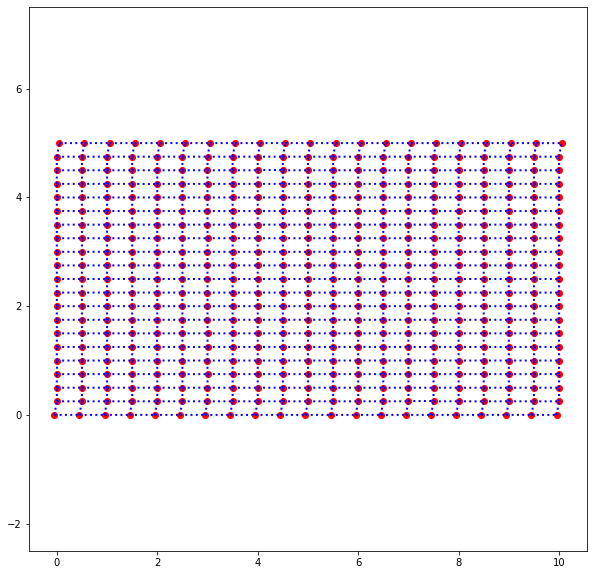

time frame: 0.0 



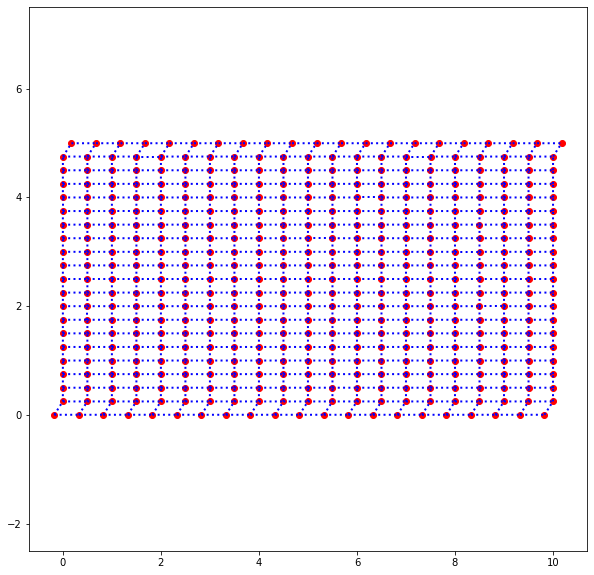

time frame: 1.0 



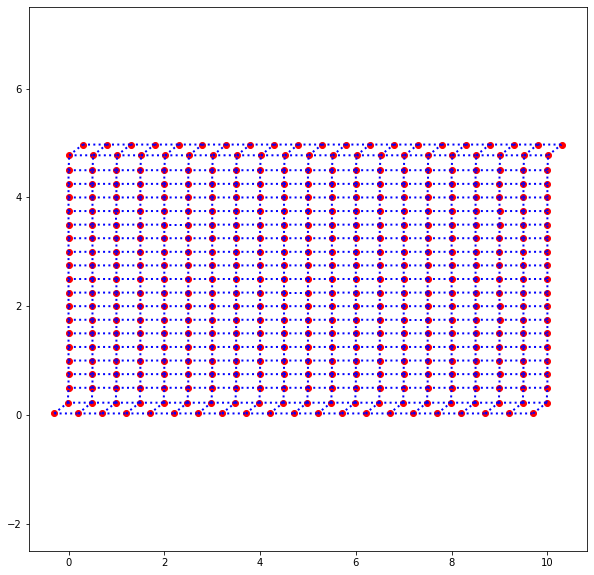

time frame: 2.0 



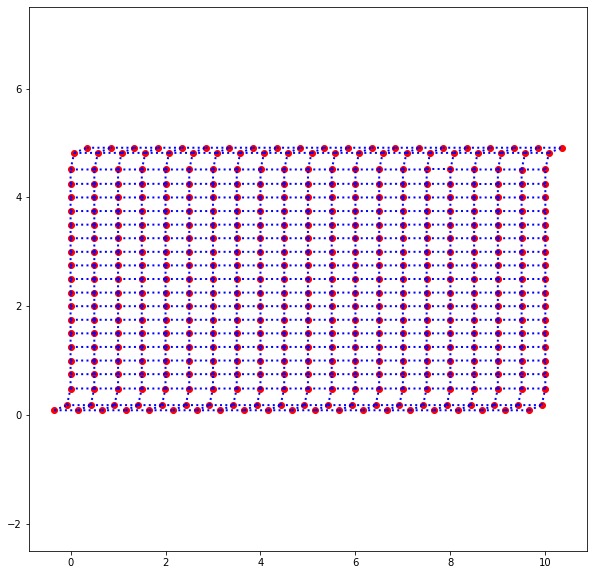

time frame: 3.0 



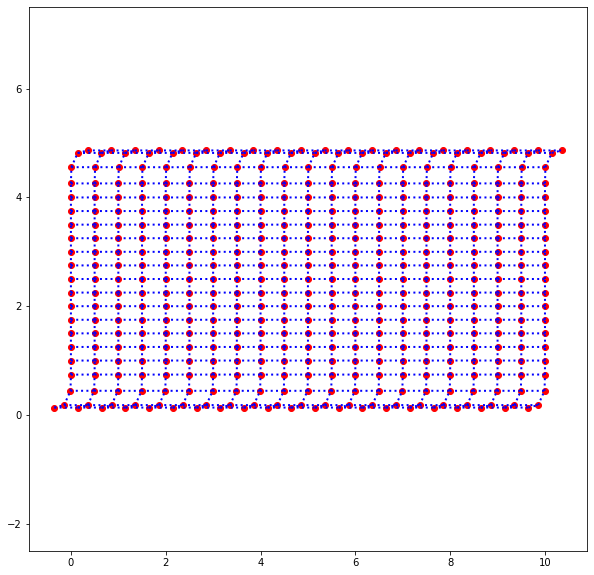

time frame: 4.0 



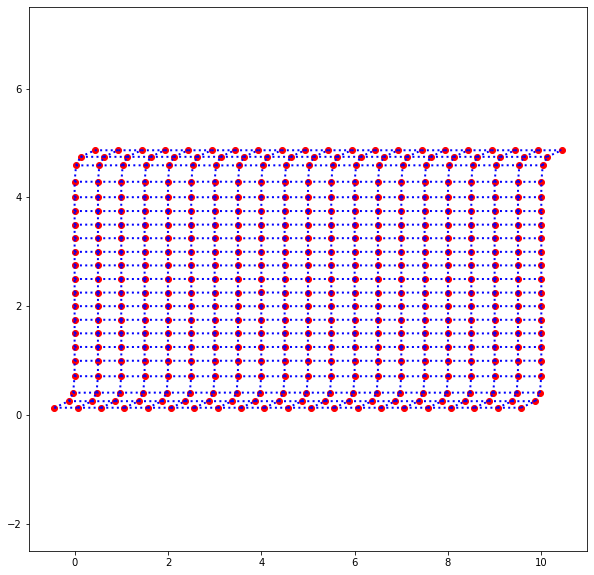

time frame: 5.0 



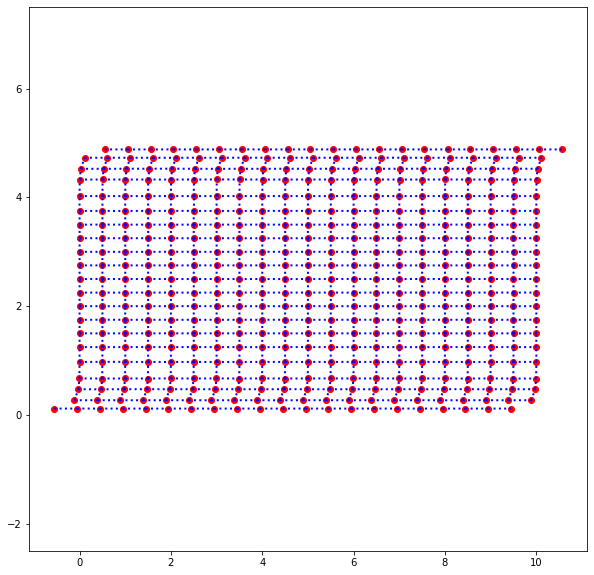

time frame: 6.0 



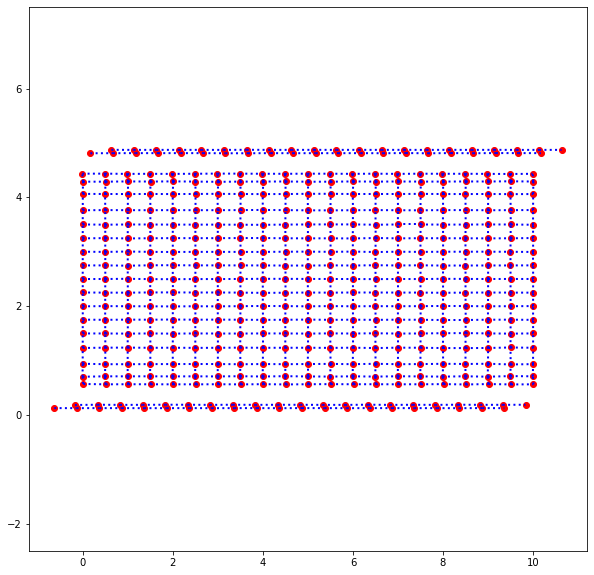

time frame: 7.0 



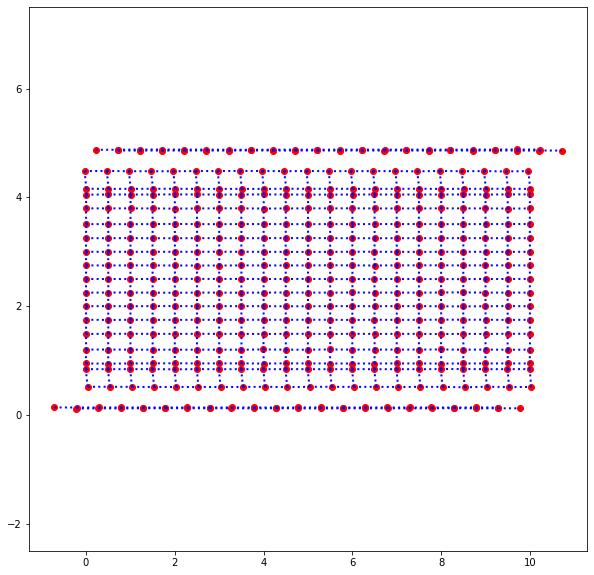

time frame: 8.0 



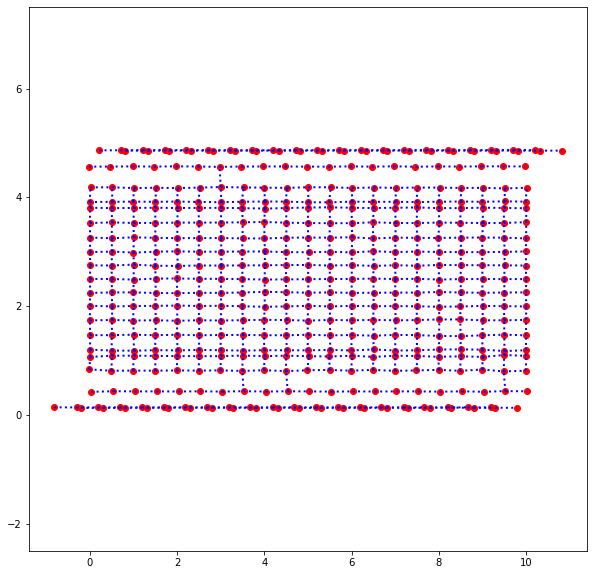

time frame: 9.0 



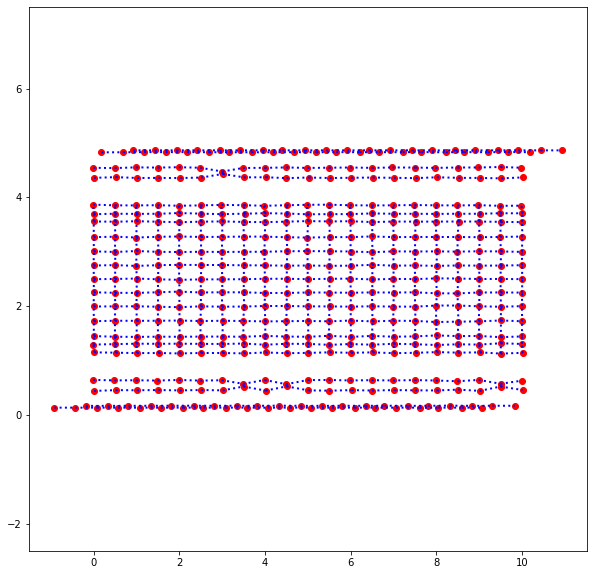

time frame: 10.0 



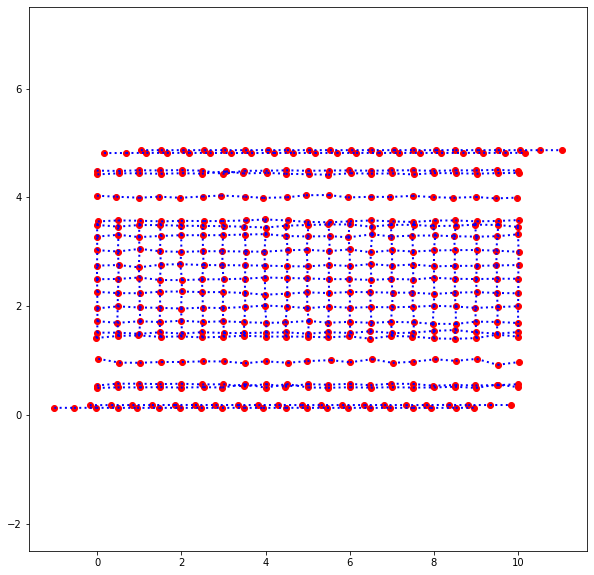

time frame: 11.0 



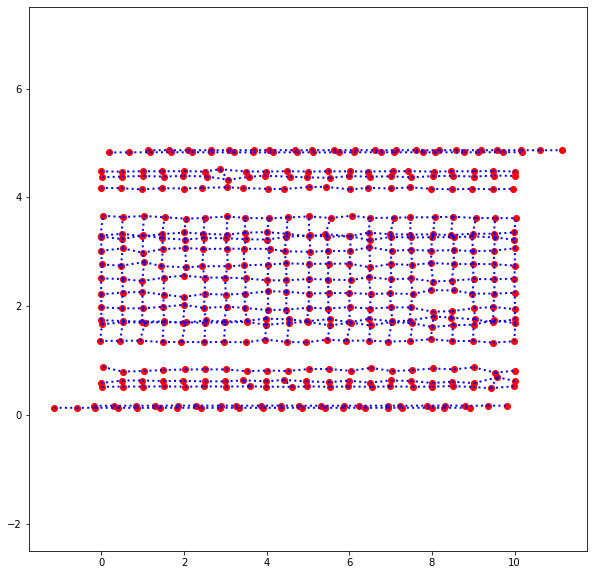

time frame: 12.0 



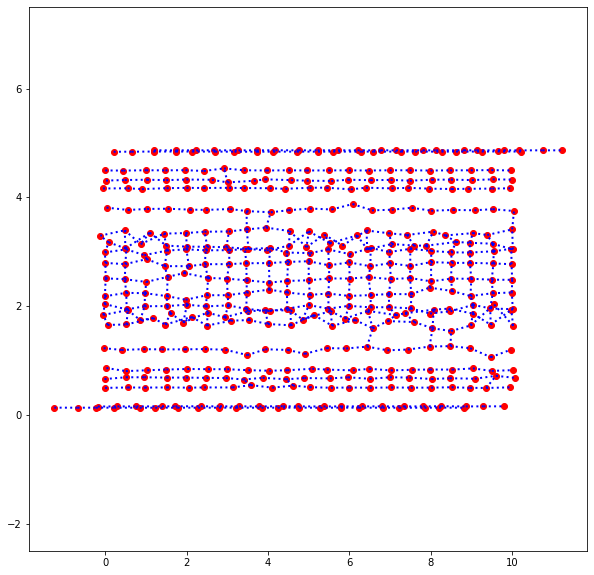

time frame: 13.0 



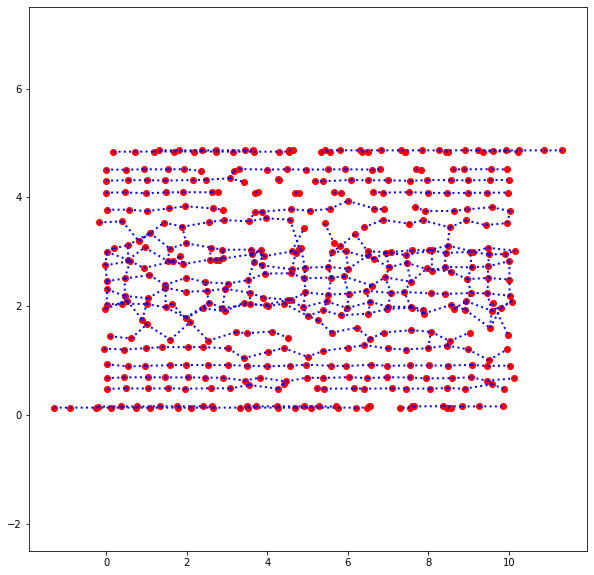

time frame: 14.0 



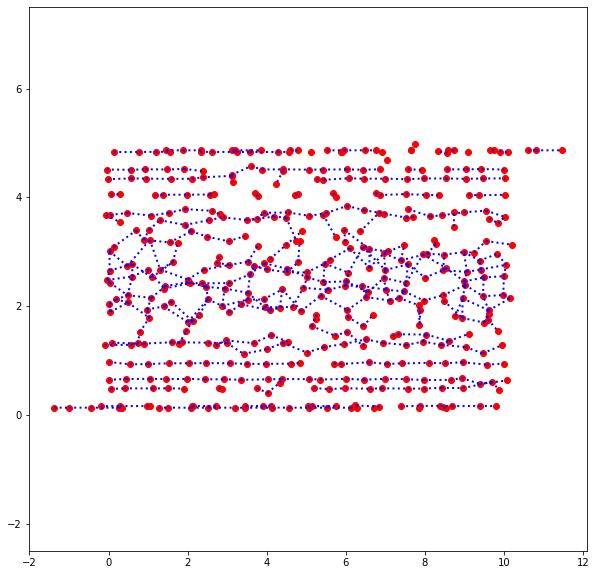

time frame: 15.0 



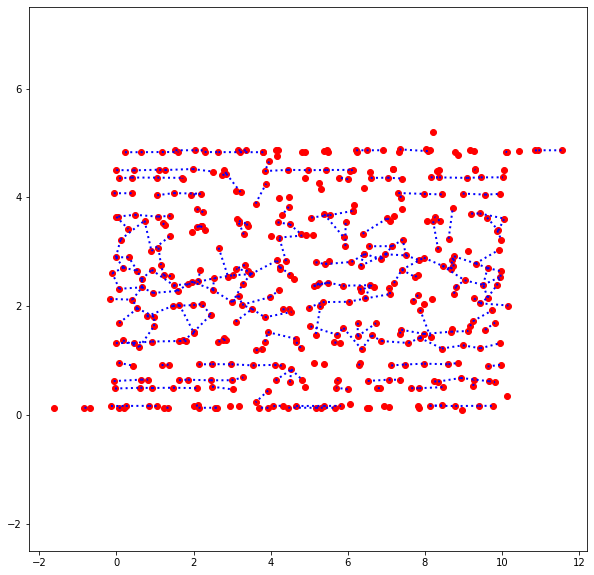

time frame: 16.0 



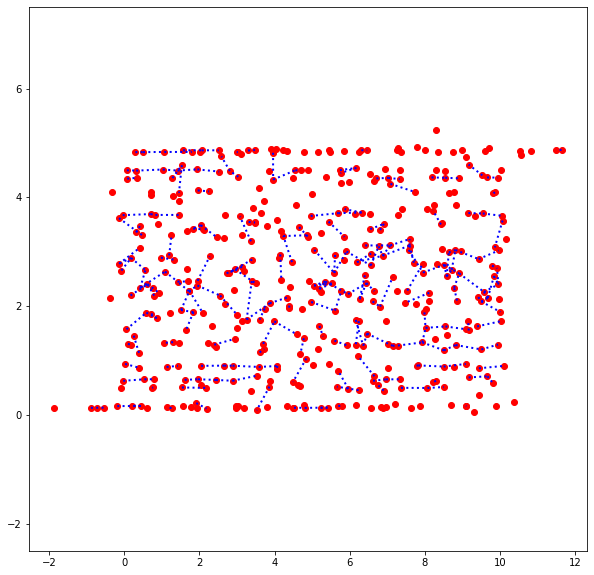

time frame: 17.0 



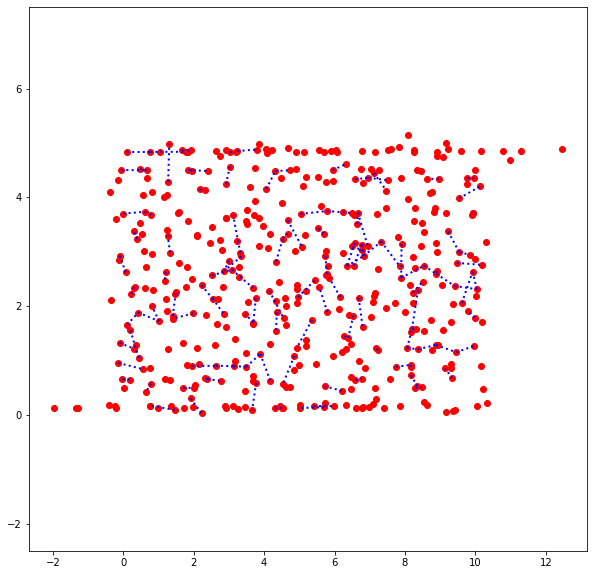

time frame: 18.0 



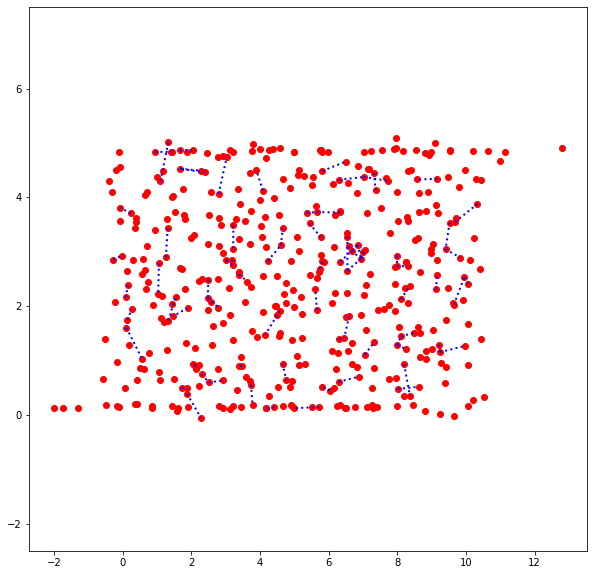

time frame: 19.0 



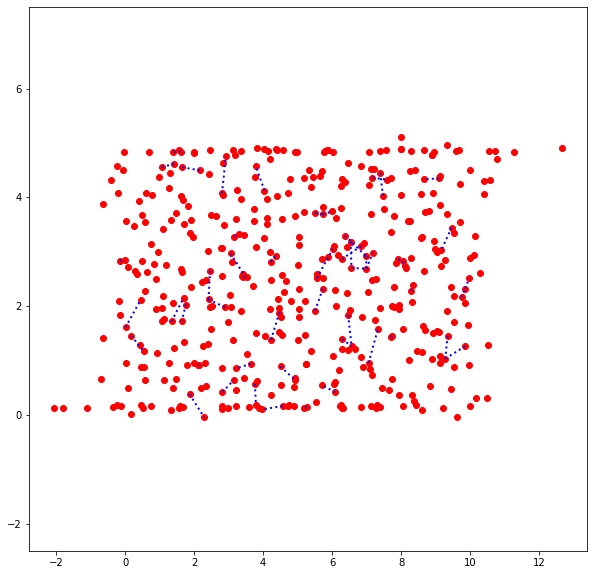

time frame: 20.0 



In [12]:
node_a = np.zeros((2, num_x * num_y))

node_a_old = np.zeros((2, num_x * num_y))

node_v = np.zeros((2, num_x * num_y))

node_u = np.zeros((2, num_x * num_y)) + 0.0001 * np.random.randn(2, num_x * num_y)

# randomness of displacement at the beginning comes from the residual deformation during manufacturing

active_node_up = []

active_node_down = []

for i in node_id:
    
    # extract loaded nodes
    
    if abs(node_y[i] - 5) <= 1e-5:
        
        # top left node
        
        active_node_up.append(i)
        
    elif abs(node_y[i] - 0) <= 1e-5:
        
        # bottom left node
        
        active_node_down.append(i)

for t in frame_t: # loop within the time frame
  
    node_a[0, active_node_up] += (1 / mass) * 0.1 # upward shear force = 1
    
    node_a[0, active_node_down] += (1 / mass) * (-0.1) # downward shear force = -1

    node_v, node_u = explicit(node_a, node_a_old, node_v, node_u, t) # update velocity and displacement of the nodes

    node_a_old[:] = node_a[:] # record acceleration in this step (element-wise operation)
    
    spring_f, neighbor_x, neighbor_y = compute_force(node_u, neighbor_x, neighbor_y) # compute the force generated by the springs
    
    node_display = node_u + np.vstack((node_x, node_y)) # compute location of the nodes
    
    plot_deformed(node_u, neighbor_x, neighbor_y) # plot the location of the nodes

    drag_f = drag_force(node_v) # incorporate drag force
    
    node_a[:] = (1 / mass) * (spring_f[:] + drag_f[:]) # compute acceleration by both the drag force and the force generated by the springs (element-wise operation)
    
    print('time frame:', t, '\n')